# Super Resolution

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import imageio
import pickle as pkl
from PIL import Image as im

mpl.rcParams['figure.dpi'] = 100


In [ ]:
anim_file = 'assets/224_baboon.gif'

with open('train_samples/gan_in224_4Xzoom_plossX0-1_monilenet_backbone_baboon.pkl', 'rb') as f:
    train_samples = pkl.load(f)
    with imageio.get_writer(anim_file, mode='I', fps=5) as writer:
      for sample in train_samples:
        writer.append_data(np.array(sample))

In [ ]:
def load_img(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  img = img[tf.newaxis, :]
  return img

1.0
0.0


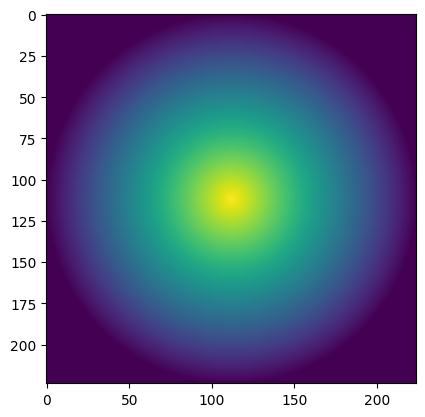

In [4]:
import numpy as np
import matplotlib.pyplot as plt

h = 224
w = 224

center = (int(w/2), int(h/2))
Y, X = np.ogrid[:h, :w]
# print(X)
# print(Y)
# print(center)

dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)


# max_dist = np.max(dist_from_center)

max_dist = h / 2

# max_dist = 50
# dist_from_center = dist_from_center - 50
dist_from_center = np.clip(dist_from_center, 0, max_dist)

dist_from_center = np.abs(dist_from_center  - max_dist) / max_dist

# dist_from_center = np.clip((dist_from_center - 0.5), 0., 1.)

print(np.max(dist_from_center))
print(np.min(dist_from_center))


plt.imshow(dist_from_center)
plt.show()


In [ ]:
def enhance_w_overlap_trim(image_path, scale, model_output_dim, overlap, trim, model, save_path):
  trimmed_model_output_dim = model_output_dim - trim
  img = load_img(image_path)
  b, height, width, d = img.shape
  print([height, width])
  numTiles = min([height, width]) // trimmed_model_output_dim
  print(numTiles)
  newDim = numTiles * scale
  print(newDim)
  upscaledDim = newDim*model_output_dim + (overlap * (numTiles - 1))
  print(upscaledDim)
  upscaled_img = tf.squeeze(tf.image.resize(
    img,
    [upscaledDim, upscaledDim],
    preserve_aspect_ratio=True))

  crops = []
  for h in range(newDim):
    for w in range(newDim):
      crop = tf.slice(upscaled_img, [max(h*model_output_dim - h*overlap, 0), max(w*model_output_dim - w*overlap, 0), 0], [model_output_dim, model_output_dim, -1])
      crops.append(crop)

  crops = [np.array([c]) for c in crops]
  # [print(c.shape) for c in crops]
  crops = [model.predict(c) for c in crops]
  crops = [np.squeeze(c) for c in crops]
  crops = [tf.slice(c, [trim, trim, 0], [trimmed_model_output_dim, trimmed_model_output_dim, -1]) for c in crops]

  overlap = overlap - trim

  rows = []
  for i in range(0, newDim*newDim, newDim):
    row = crops[i]
    for crop in crops[i+1:i+newDim]:
      left = tf.slice(row, [0, 0, 0], [-1, row.shape[1] - overlap, -1])
      right = tf.slice(crop, [0, overlap, 0], [-1, -1, -1])
      overlap_left = tf.slice(row, [0, row.shape[1] - overlap, 0], [-1, -1, -1])
      overlap_right = tf.slice(crop, [0, 0, 0], [-1, overlap, -1])
      overlap_avg = (overlap_left + overlap_right) / 2
      row = tf.concat((left, overlap_avg, right), axis=1)
    rows.append(row)

  
  whole = rows[0]
  for row in rows[1:]:
    top = tf.slice(whole, [0, 0, 0], [whole.shape[0] - overlap, -1, -1])
    bottom = tf.slice(row, [overlap, 0, 0], [-1, -1, -1])
    overlap_top = tf.slice(whole, [whole.shape[0] - overlap, 0, 0], [-1, -1, -1])
    overlap_bottom = tf.slice(row, [0, 0, 0], [overlap, -1, -1])
    overlap_avg = (overlap_top + overlap_bottom) / 2
    whole = tf.concat((top, overlap_avg, bottom), axis=0)


  whole = whole + 1
  whole = whole / 2
  whole = whole * 255
  whole = np.clip(whole, 0, 255).astype(np.uint8)

  plt.title('Original')
  plt.imshow(tf.cast(upscaled_img, tf.uint8))
  plt.show()

  plt.title(f'{scale}x enhanced')
  plt.imsave(save_path, whole)
  plt.imshow(whole)
  plt.show()

model = tf.keras.models.load_model('models/gan_in224_4Xzoom_plossX0-1_monilenet_backbone/iteration_9999.h5', compile=False)
enhance_w_overlap_trim('./dog.jpg', 4, 224, 15, 10, model, './dog_gan224.jpg')